# <h1 style="text-align:center">Extensive EDA On SIIM Pneumothorax Dataset</h1>


* [1. introduction](#section1)
* [2. Data science in Pneumothorax identification](#section2)
    * [2.1 What is Pneumothorax?](#section2)
    * [2.2 Why Datascience in Pneumothorax detection?](#section2)
* [3. About Dataset](#section3)
    * [3.1. Understanding DICCOM](#section3.1)
* [4. Analyzing metadata](#section4)
    * [4.1 Healthy vs non healthy Patients(Pneumothorax)](#section4)
    * [4.2 Analysis On Sex](#section4.2)
    * [4.3 Analysis On View position](#section4.3)
    * [4.4 Analysis On Age](#section4.4)
* [5. Analyzing images and masks](#section5)
    * [5.1 Understanding images](#section5)
    * [5.2 RLE encoding](#section5.2)
    * [5.3 Visualizing images and masks](#section5.3)
* [6. Conclusion and future steps](#section6)¶





<img src="https://image.shutterstock.com/image-vector/human-anatomy-pneumothorax-diagram-illustration-600w-1849652587.jpg" height="200px" width="1000px">




<a class="anchor" id="section1"></a>
### 1. Introduction

The impact of Artificial intellihence in the field of medicine is inevitable. One of its common application of AI in medicine includes diagnosis of medical condition by analyzing
he Digital Imaging of X-rays, CT-Scans, etc. Here we have to detect Pneumothorax from Chest X-rays. Before geting in to analysis, let us get familirize with the domain.

<a class="anchor" id="section2"></a>
### 2. Data science in Pneumothorax identification

**What is Pneumothorax?**

A pneumothorax (noo-moe-THOR-aks) is a collapsed lung. A pneumothorax occurs when air leaks into the space between your lung and chest wall. This air pushes on the outside of your lung and makes it collapse. Pneumothorax can be a complete lung collapse or a collapse of only a portion of the lung. It is basically a combination of two words Pneumo(air) and Thorax(chest). Pneumothorax is also known as lung collapse. Pneumothorax is caused by an abnormal collection of air between the parietal and visceral pleura i. e. pleural space between the lungs and chest wall. 

Pneumothorax is a relatively common respiratory disease that can occur in a wide range of patients and in various clinical settings.
Doctors will use chest Xrays to identify Pneumothorax. Based on that doctor can suggest suitable treatment.

<img src="https://www.svhlunghealth.com.au/Images/UserUploadedImages/3457/Pneumothorax%20still.jpg" width="300px">

**Why Datascience in Pneumothorax detection?**

If we are able to segment/detect regions of Pneumothorax from chest X-rays it will be useful for the doctor or we can say that it will saves a lot of time for the doctor to diagnosis.
Using a dataset with x-ray images and their diagnosis with the exact place of the air in pleura, a model could be trained to recognize Pneumothorax. Additional information about the patients could also be useful when analyzing an x-ray image.Suppose we are able to find the target region, doctors can focus on that region and identify Pneumothorax easily.


<a class="anchor" id="section3"></a>
### 3. About Dataset

We have 2 folders one containing train data and other test data:

* dicom-images-train
* dicom-images-test

Inside each folder we have DICOM (Digital Imaging and Communications in Medicine) formatted files, for some reason every single image is embedded in two more folders. Also we have a csv file which provides mask encodings for each image. 


In [1]:
import numpy as np 
import pandas as pd 
import pydicom,os,cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
print(os.listdir("../input"))

['siim-acr-pneumothorax-segmentation', 'siim-train-test']


In [2]:
# Show some images
from glob import glob
train_fns = sorted(glob('../input/siim-train-test/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('../input/siim-train-test/dicom-images-test/*/*/*.dcm'))

print(f'Number of train dicom files in folder:{len(train_fns)}')
print(f'Number of test dicom files in folder:{len(test_fns)}')

df = pd.read_csv('../input/siim-train-test/train-rle.csv')
print(df.shape)

print(f'Total no of unique images in csv file: {df["ImageId"].nunique()}')
print(f'Images with duplicate Encoded pixels, ie multiple annotations:{df[df.duplicated(subset=["ImageId"])].shape[0]}')

df.head()

Number of train dicom files in folder:12089
Number of test dicom files in folder:3205
(12954, 2)
Total no of unique images in csv file: 12047
Images with duplicate Encoded pixels, ie multiple annotations:907


ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...   
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.11028.15178752...   
3  1.2.276.0.7230010.3.1.4.8323329.10366.15178752...   
4  1.2.276.0.7230010.3.1.4.8323329.10016.15178752...   

                                       EncodedPixels  
0                                                 -1  
1  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...  
2                                                 -1  
3  514175 10 1008 29 994 30 993 32 991 33 990 34 ...  
4  592184 33 976 58 956 73 941 88 926 102 917 109...

* The csv with the labels: -1 means no Pneumothorax, othervise there is an encoding for the place of Pneumothorax.
* We have images with multiple annotation. There are about 12047 unique images in our csv file.

<a class="anchor" id="section3.1"></a>
**Understanding DICCOM**

In [3]:
# code from https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
def show_info(dataset):
    print("Filename......:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixels(dataset, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

Filename......: ../input/siim-train-test/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026/1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f, 
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: [0.168, 0.168]


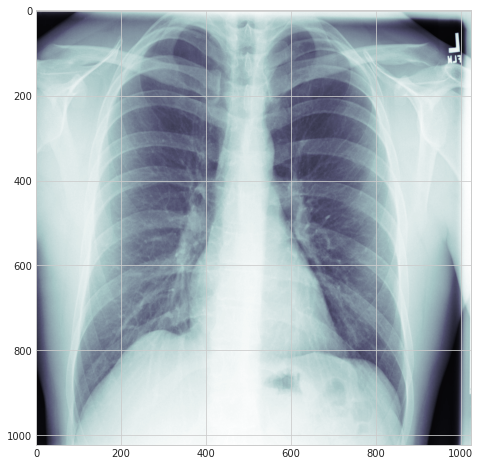

In [4]:
file_path = train_fns[0]
data = pydicom.dcmread(file_path)
show_info(data)
plot_pixels(data)

Let us create a common dataframe including all information.

In [5]:
# code idea from https://www.kaggle.com/retyidoro/eda-of-pneumothorax-dataset
missing = 0
multiple = 0
patients_data = []
for k,paths in enumerate(train_fns):
    patient = {}
    img_id = paths.split('/')[-1]
    data = pydicom.dcmread(paths)
    try:
        tmp = df[df['ImageId'] == '.'.join(img_id.split('.')[:-1])]
        
        if tmp.shape[0] > 1: 
            multiple += 1
        rle = tmp[' EncodedPixels'].values
        if rle[0] == '-1':
            pixels = rle[0]
        else:    
            pixels = [i for i in rle]
        
        patient["UID"] = data.SOPInstanceUID
        patient['EncodedPixels'] = pixels
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["filepath"] = paths
        patients_data.append(patient)
    except:
        missing += 1

print(f'We have {missing} dicom in folder which is not present in csv')
print(f'There are {multiple} images with more than 1 annotation')
df_patients = pd.DataFrame(patients_data, columns=["UID", "EncodedPixels", "Age", 
                            "Sex", "Modality", "BodyPart", "ViewPosition", "filepath"])

df_patients['Pneumothorax'] = df_patients['EncodedPixels'].apply(lambda x:0 if x == '-1' else 1)
df_patients['Pneumothorax'] = df_patients['Pneumothorax'].astype('int')
print("images with labels: ", df_patients.shape[0])
df_patients.head()    

We have 42 dicom in folder which is not present in csv
There are 624 images with more than 1 annotation
images with labels:  12047


UID EncodedPixels Age Sex  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...            -1  38   M   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...            -1  10   F   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...            -1  50   F   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...            -1  68   F   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...            -1  65   M   

  Modality BodyPart ViewPosition  \
0       CR    CHEST           PA   
1       CR    CHEST           AP   
2       CR    CHEST           AP   
3       CR    CHEST           AP   
4       CR    CHEST           AP   

                                            filepath  Pneumothorax  
0  ../input/siim-train-test/dicom-images-train/1....             0  
1  ../input/siim-train-test/dicom-images-train/1....             0  
2  ../input/siim-train-test/dicom-images-train/1....             0  
3  ../input/siim-train-test/dicom-images-train/1....             0  
4  ../input/siim-train-test/dicom-images-train/1....             0

<a class="anchor" id="section4"></a>
### 4. Analyzing metadata

### 4.1 Healthy vs non healthy Patients(Pneumothorax)

In [6]:
df_patients['Pneumothorax'].value_counts()

0    9378
1    2669
Name: Pneumothorax, dtype: int64

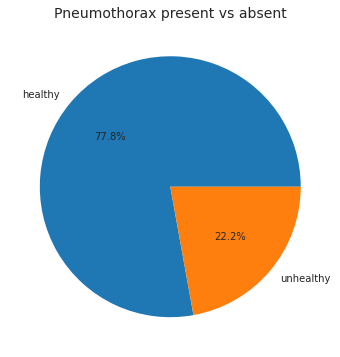

In [7]:
tmp = df_patients['Pneumothorax'].value_counts()
df_patients['Pneumothorax'] = df_patients['Pneumothorax'].astype('int')
fig, ax = plt.subplots(figsize=[10,6])
ax.pie(tmp,labels =['healthy','unhealthy'],autopct="%.1f%%");
plt.title("Pneumothorax present vs absent", fontsize=14);

We can see that only 22.2% of the people have Pneumothorax rest of the people are healthy.

<a class="anchor" id="section4.2"></a>
### 4.2 Sex

In [8]:
def plot_dual(col):
    """
    plot pie chart and bar graph
    """
    tmp = df_patients[['Pneumothorax',col]]
    tmp = tmp.groupby(by=col).mean().reset_index()
    fig, axes = plt.subplots(1,2,figsize=(15,8))
    
    tmp2 = df_patients[col].value_counts()
    axes[0].pie(tmp2,labels = tmp2.index ,
            autopct="%.2f%%",pctdistance=0.5);
    axes[0].set_title("Total count")
    sns.barplot(x=tmp[col],y=tmp['Pneumothorax'],ax=axes[1])
    axes[1].set_title(f"Pneumothorax among different {col}")
    plt.show()

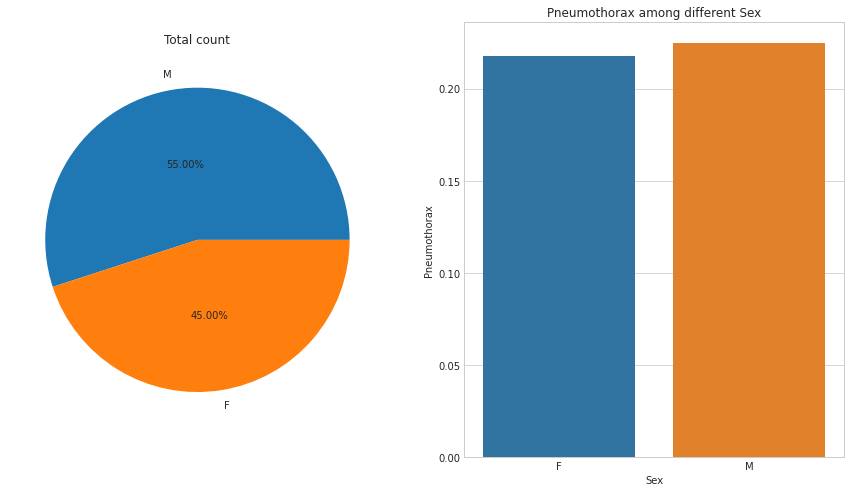

In [9]:
plot_dual('Sex')

* We can see that among 55% of whole data belongs to males and rest females
* Among females about 25% of people have Pneumothorax and rest dont have Pneumothorax
* Among maes close to 27% of people have Pneumothorax and rest dont have Pneumothorax

<a class="anchor" id="section4.3"></a>
### 4.3 View Position

The view position can be AP or PA.The abbreviations PA and AP stand for posteroanterior and anteroposterior, respectively. These describe the pathway of the x-rays through the patient to the detector (or, in the old days, film).

* In a PA projection, the front of the patient’s chest is against the detector and the x-rays pass through the back (posterior)of the patient, through the front (anterior) of the chest and then strike the detector.

* In a patient who cannot stand, the detector can be placed behind the patient’s back (while they’re lying or sitting up in a gurney or hospital bed, for example) In this scenario, the x-rays pass from the front of the patient’s chest (anterior) through the back (posterior), then strike the detector, yielding an AP view. 

* Usually PA projection is preferred for several reasons. For example, the portions of the chest closest to the detector are the sharpest and least magnified on the image. 


It will be nice if we are able to see the mask of patients with pneumothorax and distinguish between AP and PA. But before that we have to generate the mask with rle encoding.

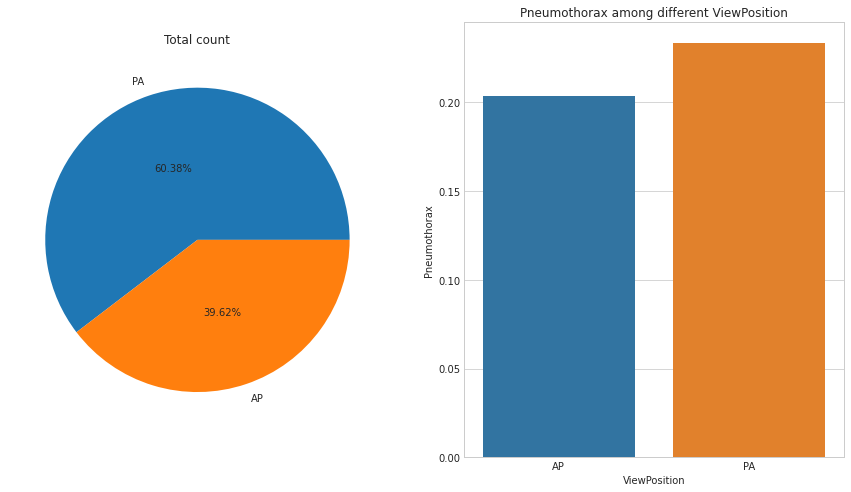

In [10]:
plot_dual('ViewPosition')

* We can see that among 60.38% of whole data belongs to 'PA' position and rest 'AP' position
* Among AP 21% of people have Pneumothorax and rest dont have Pneumothorax
* Among PA close to 28% of people have Pneumothorax and rest dont have Pneumothorax


<a class="anchor" id="section4.4"></a>
### 4.4 Age

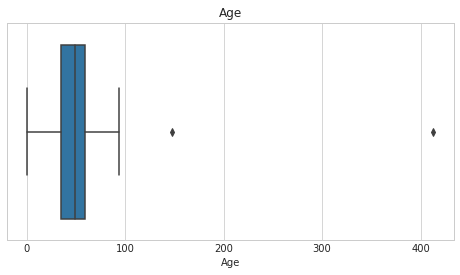

In [11]:
df_patients['Age'] = df_patients['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,4))
sns.boxplot(df_patients['Age'])
axes.title.set_text(f'Age')
plt.show()

In [12]:
df_patients[df_patients['Age'] > 100]

UID EncodedPixels  Age  \
1204  1.2.276.0.7230010.3.1.4.8323329.11106.15178752...            -1  413   
9624  1.2.276.0.7230010.3.1.4.8323329.4830.151787518...            -1  148   

     Sex Modality BodyPart ViewPosition  \
1204   F       CR    CHEST           AP   
9624   M       CR    CHEST           PA   

                                               filepath  Pneumothorax  
1204  ../input/siim-train-test/dicom-images-train/1....             0  
9624  ../input/siim-train-test/dicom-images-train/1....             0


We have few outliers. Might be mistake from dataentry. We have ages above 120, logically which is not correct. We will remove those values

In [13]:
df_patients = df_patients.drop(df_patients[df_patients['Age'] > 100].index)
print(df_patients.shape)

(12045, 9)


**Let us see how Age is distributed among healthy and non healthy perosons**

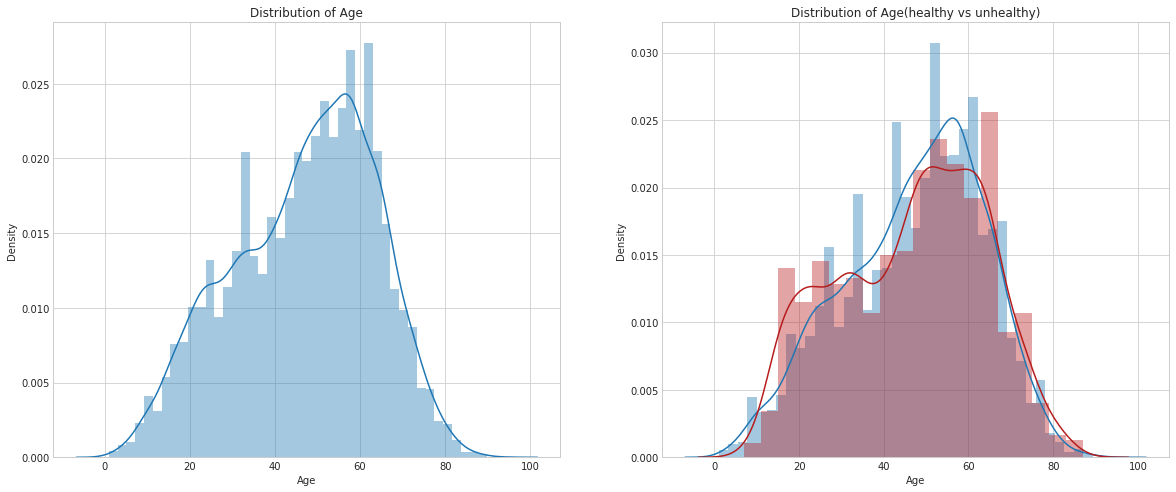

In [14]:
non_healthy = df_patients[df_patients['Pneumothorax'] == 1] 
healthy = df_patients[df_patients['Pneumothorax'] == 0]

df_patients['Age'] = df_patients['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
sns.distplot(df_patients['Age'],ax=axes[0])
axes[0].title.set_text('Distribution of Age')
sns.distplot(healthy['Age'],ax=axes[1])
sns.distplot(non_healthy['Age'],ax=axes[1],color='#B71C1C')
axes[1].title.set_text('Distribution of Age(healthy vs unhealthy)')
plt.show()

**We will get more overview of we were able to see at what age Pneumothorax is more severe among males and females**


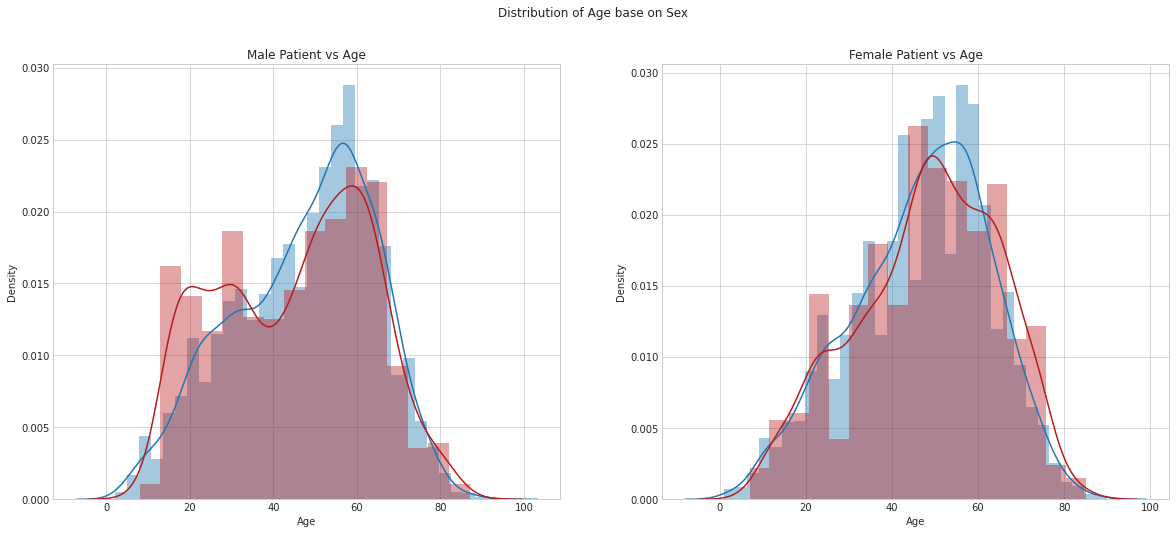

In [15]:

tmp_male = df_patients[df_patients['Sex'] == 'M'] 
tmp_female = df_patients[df_patients['Sex'] == 'F'] 

non_healthy_M = tmp_male[tmp_male['Pneumothorax'] == 1] 
healthy_M = tmp_male[tmp_male['Pneumothorax'] == 0]
non_healthy_F = tmp_female[tmp_female['Pneumothorax'] == 1] 
healthy_F = tmp_female[tmp_female['Pneumothorax'] == 0]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
sns.distplot(healthy_M['Age'],ax=axes[0])
sns.distplot(non_healthy_M['Age'],ax=axes[0],color='#B71C1C')
axes[0].set_title('Male Patient vs Age')
sns.distplot(healthy_F['Age'],ax=axes[1])
sns.distplot(non_healthy_F['Age'],ax=axes[1],color='#B71C1C')
axes[1].set_title('Female Patient vs Age')
plt.suptitle(f'Distribution of Age base on Sex')
plt.show()

* Among males with 16-25 years of age chances of pneumothorax is high. However this is based on a small amount of data.

<a class="anchor" id="section5"></a>
### 5 Analyzing images and masks

### 5.1 Understanding Images
Let us see wheather train and test images are close by analyzing their mean.

In [16]:
# check the train images
means = []
for fn in tqdm(train_fns):
    img = pydicom.read_file(fn).pixel_array
    means.append(img.mean())
print("Train mean: ", np.mean(means))

# check the test images
means = []
for fn in tqdm(test_fns):
    img = pydicom.read_file(fn).pixel_array
    means.append(img.mean())
print("Test mean: ", np.mean(means))

  0%|          | 5/3205 [00:00<01:15, 42.64it/s]

Train mean:  125.03749605447524


100%|██████████| 3205/3205 [01:05<00:00, 49.30it/s]

Test mean:  124.62664661734784


We can see that both have close mean. So train and test can exhibit a close behaviour.

<a class="anchor" id="section5.2"></a>
### 5.2 RLE Encoding

Run-length encoding (RLE) is a form of lossless data compression in which runs of data are stored as a single data value and count, rather than as the original run.
Lets understand how to generate masks, if EncodedPixels(RLE) are given instead of mask images with an example.

Let us take an example, for image with UID '1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951' RLE is as follows: 

['209126 1 1019 6 1015 10 1012 13 1010 14 1008 16 1007 16 1006 18 1004 20 1003 20 1002 22 1001 22 1001 23 999 24 999 24 999 25 997 26 997 27 996 27 996 27 996 28 995 28 995 28............1005 18 1010 12']

This means that when we flatten a 1024x1024 image to 1024 * 1024 =1048576, starting from 209126 pixels we have the next 1 pixel as a mask (a region with Pneumothorax). Now we are at 209127,  Now move 1019 pixels front. ie, from 209127 to 210145. Next starting from 210145 pixels, we have the next 6 pixels as a mask. I hope you get it now

You can read more about RLE [here.](http://https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)




In [17]:
# Here out RLE encoding is little bit different
def rle2mask(rles, width, height):
    """
    
    rle encoding if images
    input: rles(list of rle), width and height of image
    returns: mask of shape (width,height)
    """
    
    mask= np.zeros(width* height)
    for rle in rles:
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height).T

<a class="anchor" id="section5.3"></a>
### 5.3 Visualizing Images and Masks

Some random images and masks if present

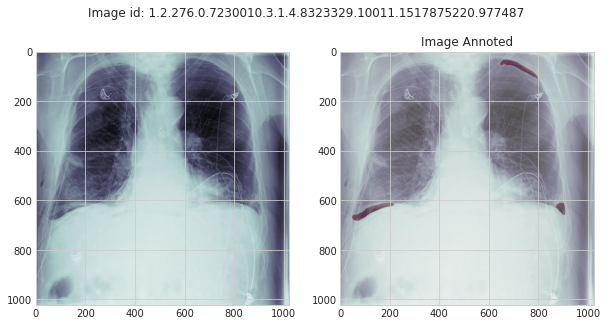

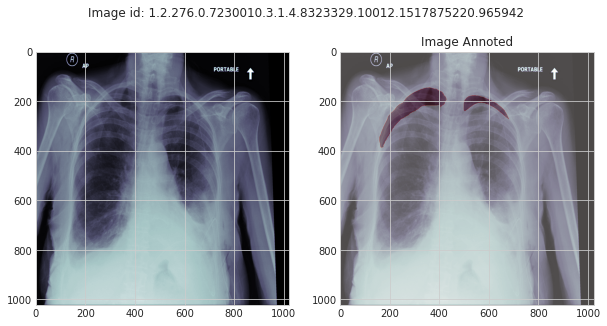

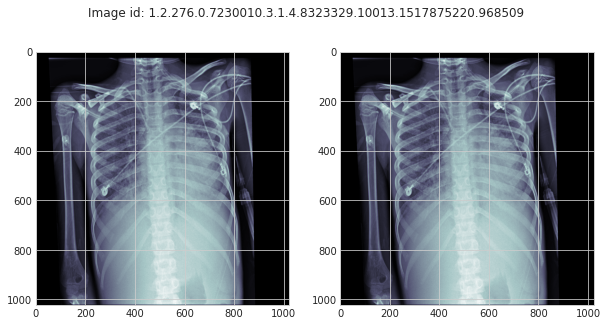

In [18]:
for file in train_fns[13:16]:
    data = pydicom.dcmread(file)
    image = data.pixel_array
    id_ = '.'.join(file.split('/')[-1].split('.')[:-1])
    rle = df[df['ImageId'] == str(id_)][' EncodedPixels'].values
    if rle[0] == '-1':
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(image,cmap='bone')
        axes[1].imshow(image,cmap='bone')
        plt.suptitle(f'Image id: {id_}')
        plt.show()
    else:
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(image,cmap='bone')
        mask = rle2mask(rle,image.shape[0],image.shape[1])
        axes[1].imshow(image,cmap='bone')
        axes[1].imshow(mask,alpha=0.3,cmap='Reds')
        axes[1].set_title('Image Annoted')
        plt.suptitle(f'Image id: {id_}')
        plt.show()

Let us visualize better

In [19]:
def bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin, cmin, rmax, cmax #ymin,xmin,ymax,cmax


def plot_imgs(n,df):
    for i in range(n):
        idx = np.random.randint(0,df.shape[0])
        tmp = df.iloc[idx]
        # path of file
        path = tmp['filepath']
        encoding = tmp['EncodedPixels']
        image = pydicom.dcmread(path).pixel_array
        fig, axes = plt.subplots(1,4, figsize=(20,15))
        axes[0].imshow(image, cmap='bone')
        axes[0].set_title('Image')
        mask = rle2mask(encoding,image.shape[0],image.shape[1])
        axes[1].imshow(mask,cmap='gray')
        axes[1].set_title('Mask')
        axes[2].imshow(image,cmap='bone')
        axes[2].imshow(mask,alpha=0.3,cmap='Reds')
        axes[2].set_title('Image + mask')
        rmin, cmin, rmax, cmax = bounding_box(mask)
        image_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        cv2.rectangle(image_rgb, (cmin,rmin),(cmax,rmax), (255,255,0), 5)
        axes[3].imshow(image_rgb)
        axes[3].imshow(mask,alpha=0.3,cmap='Reds')
        axes[3].set_title('Image Box Annoted')
        plt.show()

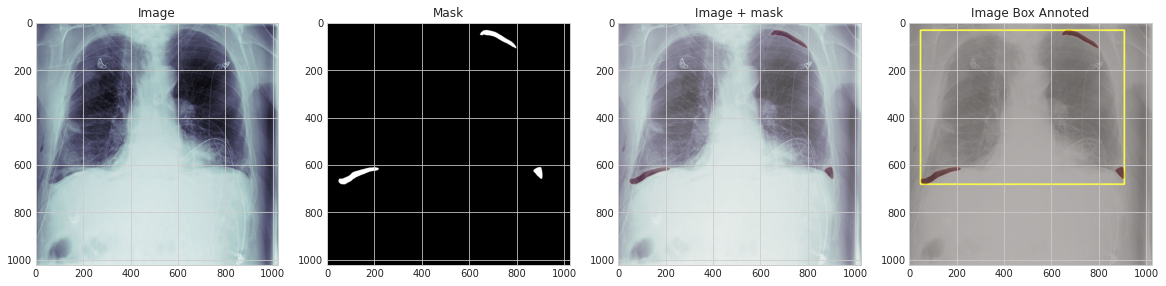

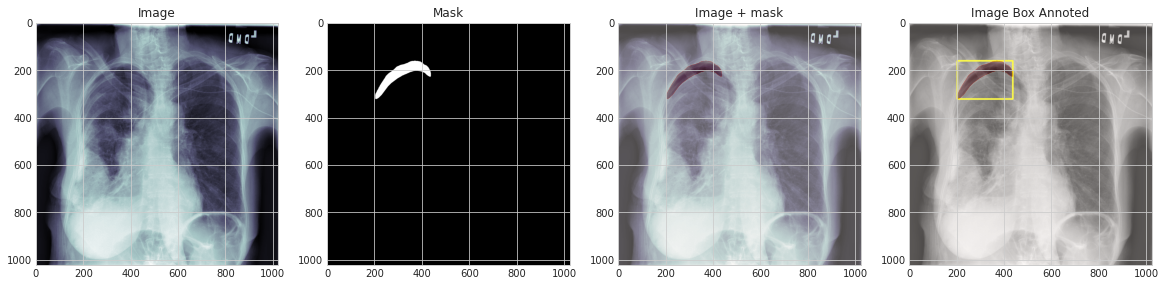

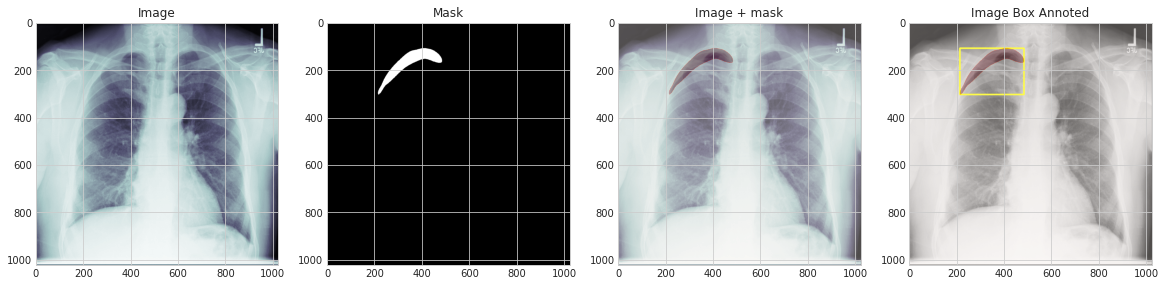

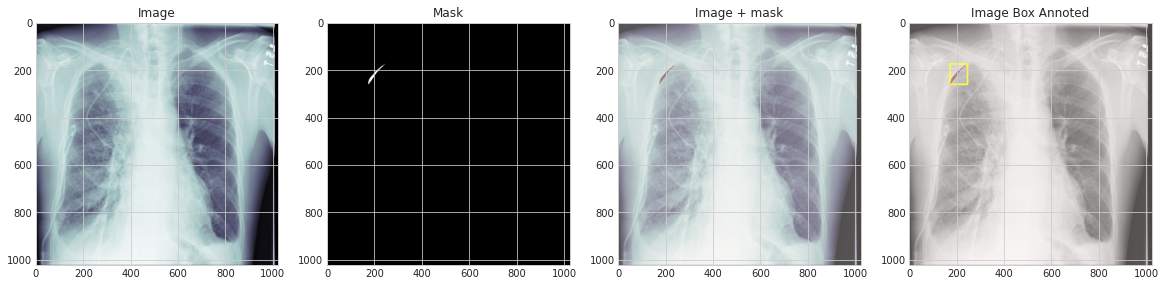

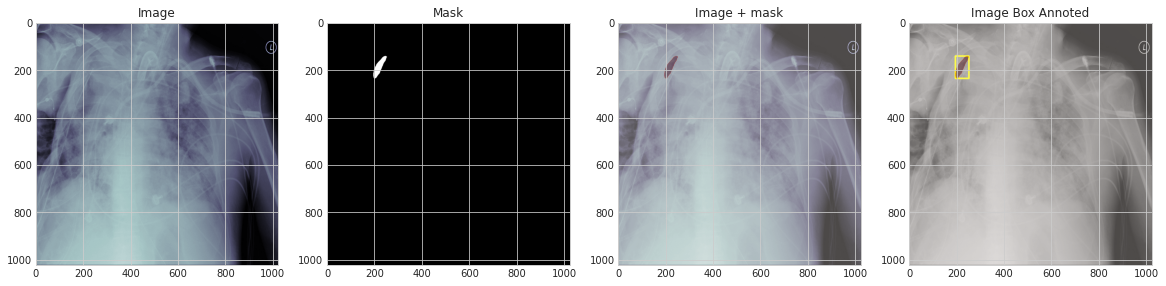

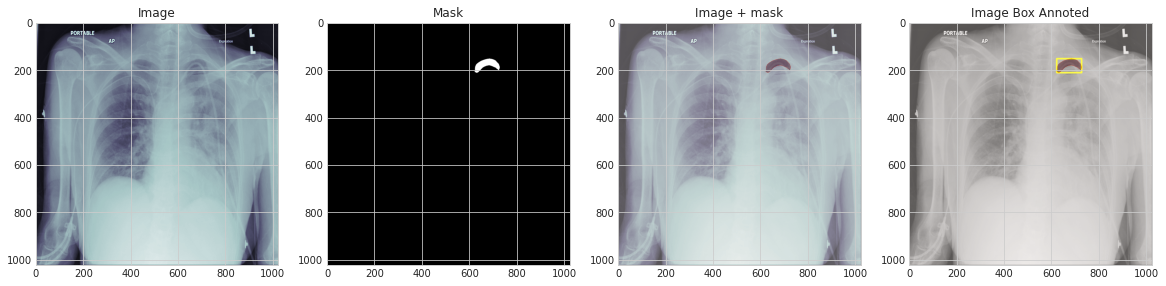

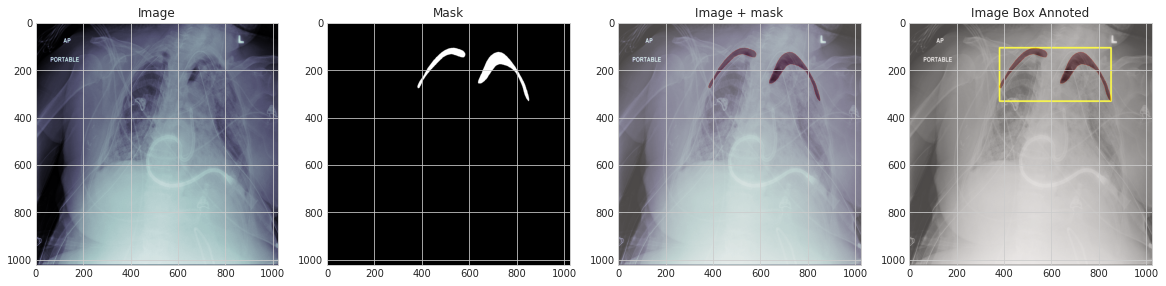

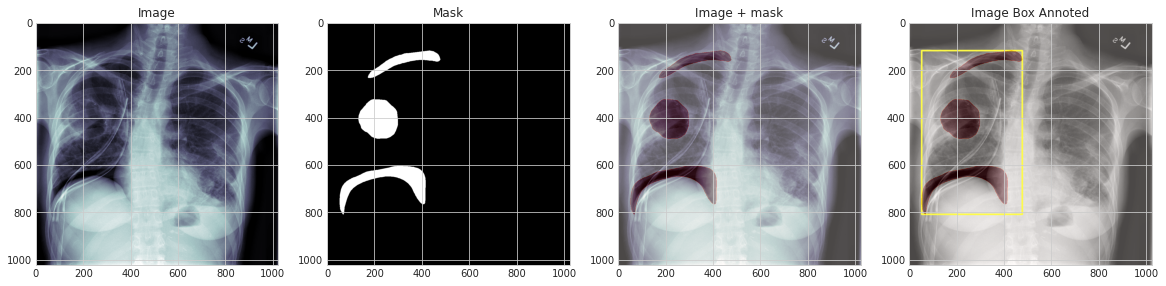

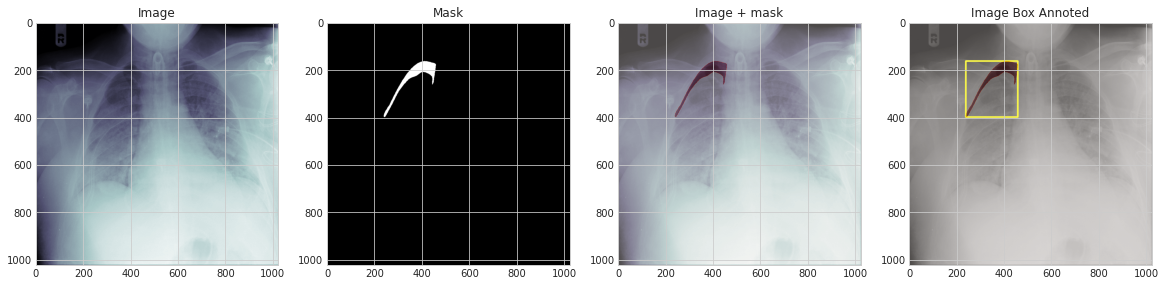

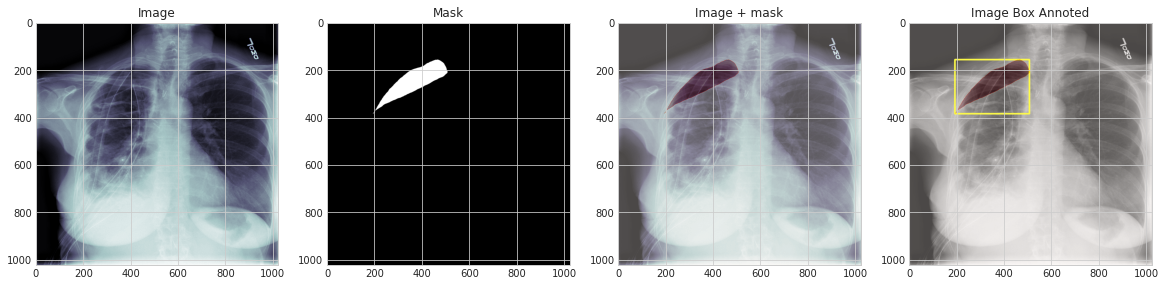

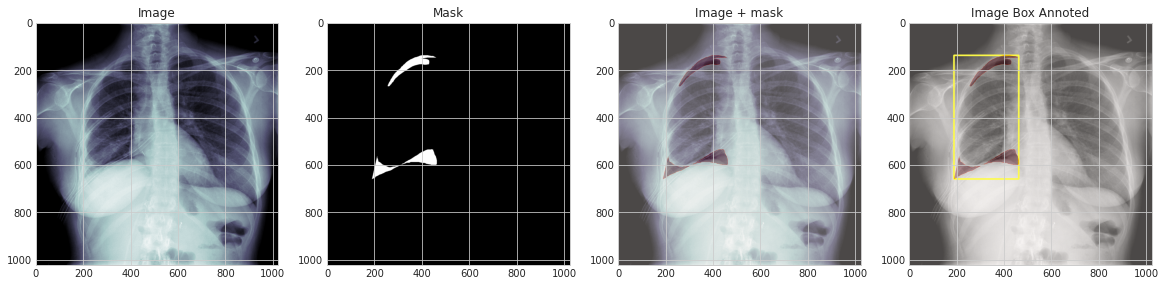

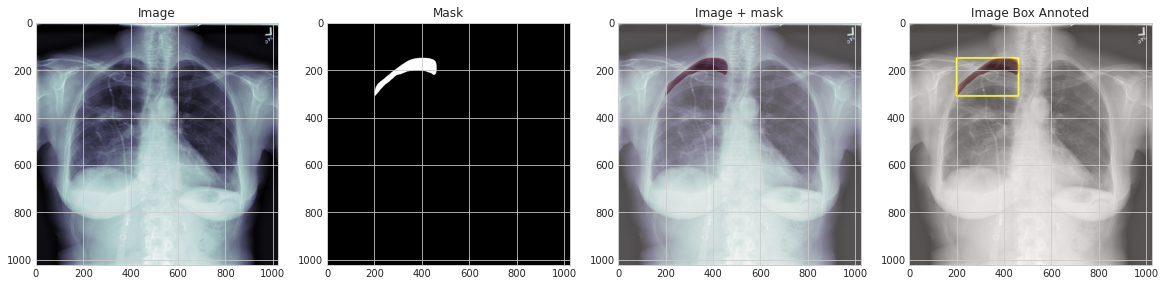

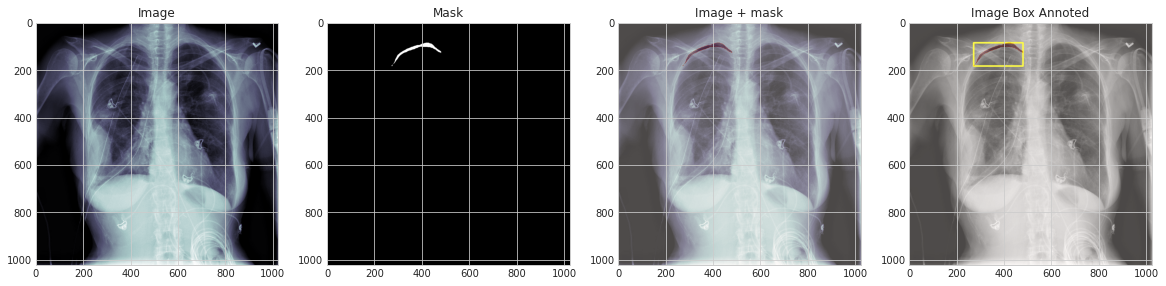

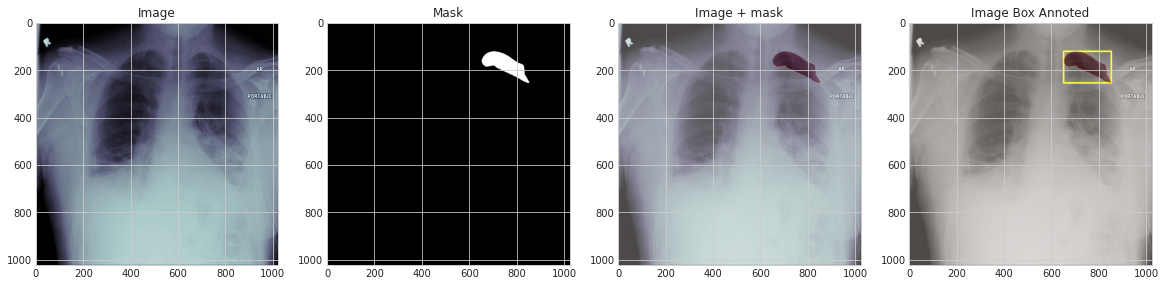

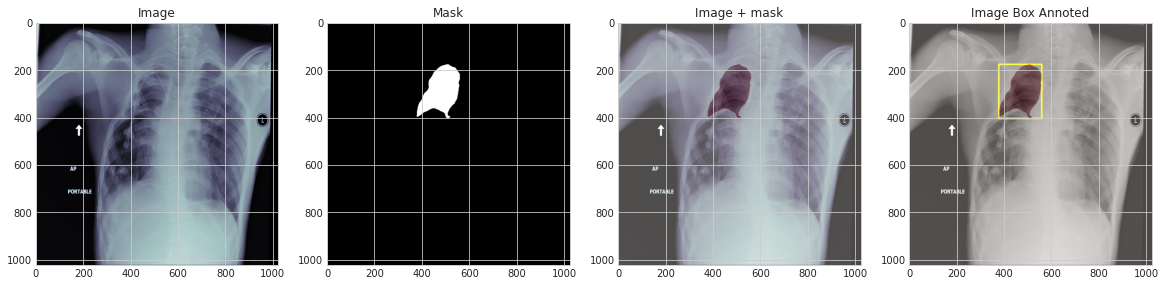

In [20]:
tmp = df_patients[df_patients['Pneumothorax'] == 1].reset_index(drop=True)
plot_imgs(15,tmp)

In [21]:
#saving file
df_patients.to_csv('processed.csv',index=False)

dff = pd.read_csv('processed.csv')
dff.head()

UID EncodedPixels  Age Sex  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...            -1   38   M   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...            -1   10   F   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...            -1   50   F   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...            -1   68   F   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...            -1   65   M   

  Modality BodyPart ViewPosition  \
0       CR    CHEST           PA   
1       CR    CHEST           AP   
2       CR    CHEST           AP   
3       CR    CHEST           AP   
4       CR    CHEST           AP   

                                            filepath  Pneumothorax  
0  ../input/siim-train-test/dicom-images-train/1....             0  
1  ../input/siim-train-test/dicom-images-train/1....             0  
2  ../input/siim-train-test/dicom-images-train/1....             0  
3  ../input/siim-train-test/dicom-images-train/1....             0  
4  ../input/siim-train-test/dicom-images-train/1....             0

<a class="anchor" id="section6"></a>
### 6. Conclusion and future steps

We have did an extensive analysis of the data and we got a clear picture on how to procees further. We can consider this as a segmentation problem. Initially We can think of two approaches:

1. Image segmentation: This is straight forward approach where we will do a segmentation of affected regions of all images.

2. Image classification + segmentation: In this approach we will have 2 models. One to classify weather the image has pneumothorax and second to segment it.

